# Classification tourism

Probar
https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models

In [2]:
import os
import pandas as pd
import numpy as np
import openpyxl as px
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
df = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism.csv', sep=";", decimal=".", encoding="utf-8")
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df

,Suecia,Pib Pc,IPC Armonizado,Desempleo Armonizado,Asientos ofertados,IPC España Armonizado,Llegadas a AGP Suecia,Mortalidad,Indice del consumidor,Búsquedas hacia AGP total,Búsquedas hacia AGP 3 meses,Búsquedas hacia AGP 6 meses,Fecha
0,7351.0,8520.0,86.02,6.8,-1,81.16,4240.0,8217,1.9,0,0,0,2005-01-01
1,8935.0,8520.0,86.46,6.8,-1,81.35,4897.0,7868,1.6,0,0,0,2005-02-01
2,12503.0,8520.0,86.68,6.8,-1,82.07,5368.0,9333,1.8,0,0,0,2005-03-01
3,11537.0,9010.0,86.83,8.7,-1,83.24,6439.0,7968,-0.9,0,0,0,2005-04-01
4,14012.0,9010.0,86.93,8.7,-1,83.37,5808.0,7430,-0.3,0,0,0,2005-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,12310.0,128.38,7.2,-1,121.06,26331.0,0,-13.9,0,0,0,2024-08-01
236,0.0,12310.0,128.38,7.2,-1,121.06,26331.0,0,-13.9,0,0,0,2024-09-01
237,0.0,12310.0,128.38,7.2,-1,121.06,26331.0,0,-13.9,0,0,0,2024-10-01
238,0.0,12310.0,128.38,7.2,-1,121.06,26331.0,0,-13.9,0,0,0,2024-11-01


### Shuffled train test split

In [4]:
train, test = train_test_split(df, test_size=0.3)
test, val = train_test_split(test, test_size=0.5)

Y_train = train['Suecia']
X_train = train.drop(columns=['Suecia'])
print(X_train.shape)

Y_test = test['Suecia']
X_test = test.drop(columns=['Suecia'])
print(X_test.shape)


Y_val = val['Suecia']
X_val = val.drop(columns=['Suecia'])
print(X_val.shape)


(168, 12)
(36, 12)
(36, 12)


### Time-based train test split

In [5]:
dfs_by_year = {}
for year in range(df['Fecha'].dt.year.min(), df['Fecha'].dt.year.max()):
    dfs_by_year[year] = df[df['Fecha'].dt.year == year]

# Train with 2005 to 2015
train = pd.concat([v for k, v in dfs_by_year.items() if k >= 2005 and k < 2016])
X_train_2005_2015 = train.drop(columns=['Suecia', 'Fecha'])
Y_train_2005_2015 = train['Suecia']
print(X_train_2005_2015.shape)

# Test with 2016
X_test_2016 = dfs_by_year[2016].drop(columns=['Suecia', 'Fecha'])
Y_test_2016 = dfs_by_year[2016]['Suecia']
print(X_test_2016.shape)

# Rest is reserved for further validation


(132, 11)
(12, 11)


## Analysis on temporal data

In [6]:
# Data scaling
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train_2005_2015)
X_train_2005_2015_scaled = pd.DataFrame(scaler_X.transform(X_train_2005_2015), columns=X_train_2005_2015.columns)
X_test_2016_scaled = pd.DataFrame(scaler_X.transform(X_test_2016), columns=X_test_2016.columns)

scaler_Y = StandardScaler()
scaler_Y.fit(Y_train_2005_2015.values.reshape(-1, 1))
Y_train_2005_2015_scaled = scaler_Y.transform(Y_train_2005_2015.values.reshape(-1, 1)).flatten()
Y_test_2016_scaled = scaler_Y.transform(Y_test_2016.values.reshape(-1, 1)).flatten()


<Figure size 1500x1000 with 0 Axes>

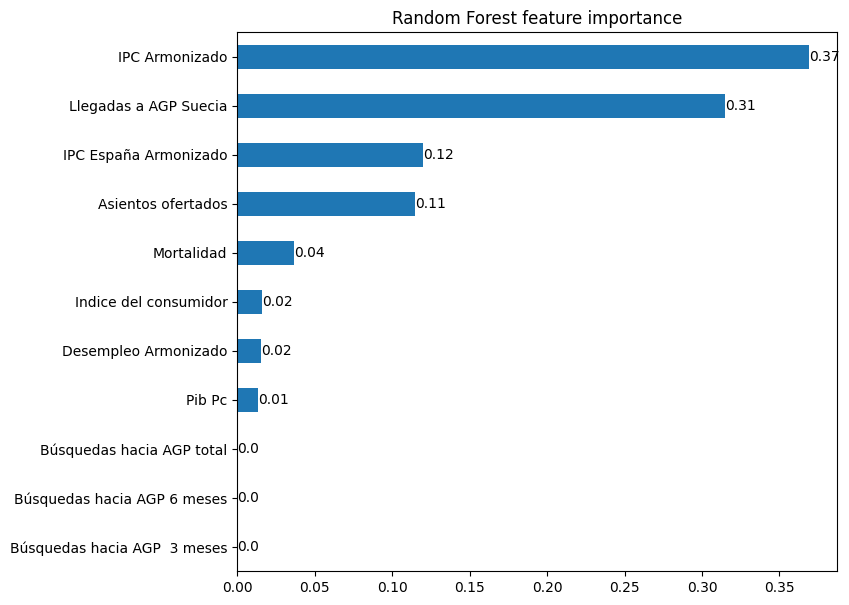

In [7]:
RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
RF.fit(X_train_2005_2015_scaled, Y_train_2005_2015)
plt.figure(figsize=(15, 10))
# plot_tree(RF.estimators_[0], filled=True, feature_names=X_train_2005_2015_scaled.columns, fontsize=8)

importance = RF.feature_importances_
feature_importance = pd.DataFrame(importance, index=X_train_2005_2015_scaled.columns, columns=['importance'])
sorted_feature_importance = feature_importance.reindex(feature_importance.importance.abs().sort_values(ascending=True).index)
sorted_feature_importance.plot(kind='barh', figsize=(10, 7))
plt.title('Random Forest feature importance')
plt.legend().remove()
plt.subplots_adjust(left=0.3)
for i, v in enumerate(sorted_feature_importance.importance):
    plt.text(v, i, str(f"{round(v, 2)}"), color='black', va='center')
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
pred = RF.predict(X_test_2016_scaled)
print(pd.DataFrame({'True': Y_test_2016, 'Predicted': pred}))
mse = mean_squared_error(Y_test_2016, pred)
r2 = r2_score(Y_test_2016, pred)
evs = explained_variance_score(Y_test_2016, pred)
print("MSE: ", mse)
print("R2: ", r2)
print("EVS: ", evs)

# sns.pairplot(pd.concat([X_train_2005_2015_scaled, Y_train_2005_2015], axis=1))

        True     Predicted
132  30342.0  34026.155000
133  45018.0  32512.496667
134  49979.0  32951.386667
135  39938.0  46861.870000
136  47598.0  41607.600000
137  47057.0  43627.480000
138  57519.0  45711.290000
139  31991.0  42888.970000
140  34787.0  42677.230000
141  67230.0  48691.280000
142  75614.0  34459.532000
143  27315.0  34505.580000
MSE:  247084084.51971433
R2:  -0.2184558886757959
EVS:  -0.03160077224401925


In [9]:
# XAI
import shap
shap.initjs()
xai = shap.TreeExplainer(RF)

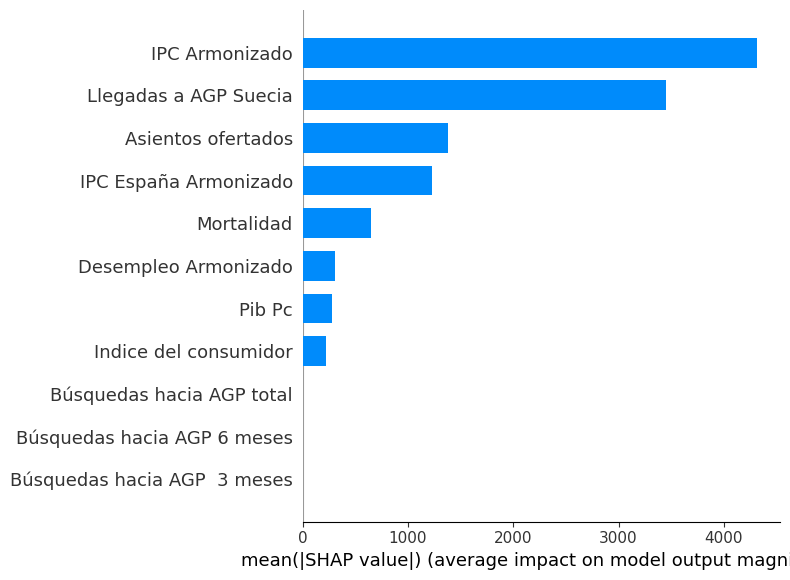

In [10]:
shap_values_prev = xai.shap_values(X_train_2005_2015_scaled)
shap.summary_plot(shap_values_prev, X_train_2005_2015_scaled, plot_type='bar')

Pib Pc 	-->	 [ 59.25479948  27.88799932  69.72617741 305.74293734 380.98414693
 344.75883607  95.27873116 127.15102616 152.13733607 104.8691177
  52.57823842  85.75023055]
IPC Armonizado 	-->	 [8812.44630242 7923.9185226  7144.56296474 8958.2882584  8201.56834604
 8430.60583846 9286.29557375 9053.84241071 8549.18613962 9020.80432665
 6701.33948269 7134.88738277]
Desempleo Armonizado 	-->	 [-426.74850976 -449.66033301 -357.01854073 -269.26500592 -457.1242323
 -345.75419057  229.83299568  171.34106973  274.52722729  387.39932221
 -475.35542166 -420.34866325]
Asientos ofertados 	-->	 [2082.16445471 2025.20576946 2306.92963371 2707.97606661 2397.62541324
 3188.15290104 3218.2703408  3102.27708617 2800.19565657 3436.40484557
 2404.8334736  2425.36987946]
IPC España Armonizado 	-->	 [-1283.42719633 -1032.32980267  -654.49789547  1625.06153357
  2572.50492395  2825.79807119   773.34825206  -573.76021766
  2195.5704445   2933.13926323  2465.91857179  2092.34953399]
Llegadas a AGP Suecia 	-->	 

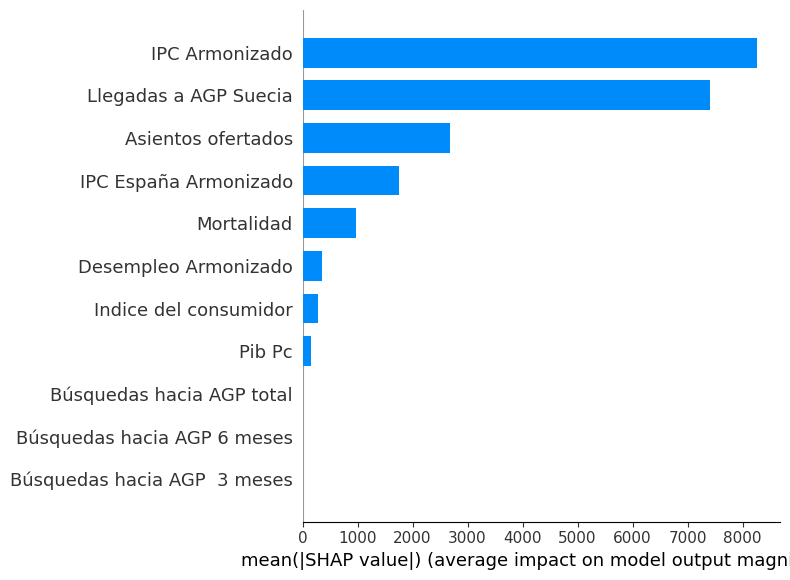

In [11]:
shap_values = xai.shap_values(X_test_2016_scaled)
for i in range(len(shap_values.T)):
    print(X_test_2016_scaled.columns[i], "\t-->\t", shap_values.T[i])
shap.summary_plot(shap_values, X_test_2016_scaled, plot_type='bar')


In [13]:
# pred, xai = predict(RF, X_train_2005_2015, X_test_2016_scaled, Y_test_2016, distance_metric='manhattan')
# print("Mean distance:", xai['Distance'].mean())
# xai

# ax = sns.scatterplot(data=xai, x='Previous explained importance', y='Test explained importance', hue='Distance')
# for i, txt in enumerate(xai.index):
#     ax.text(xai['Previous explained importance'][i]+0.05, xai['Test explained importance'][i], txt, ha="left", fontsize=8, color='grey', alpha=0.8)
# ax.add_line(plt.Line2D([xai['Previous explained importance'].min(), xai['Previous explained importance'].max()], [xai['Test explained importance'].min(), xai['Test explained importance'].max()], color='red', alpha=0.4, linewidth=2, linestyle='--'))
# xai.sort_values(by='Distance', ascending=False)

# Results over time

R2:  -0.14245238204428934
R2:  -0.21175076927962855
R2:  -0.3285496659465299
R2:  -0.2957580112769478
R2:  -0.23752404551164452
R2:  -0.2788948148808774
R2:  0.3828842497879512
R2:  0.2659529749616708
R2:  -0.021894623452980877
R2:  0.0


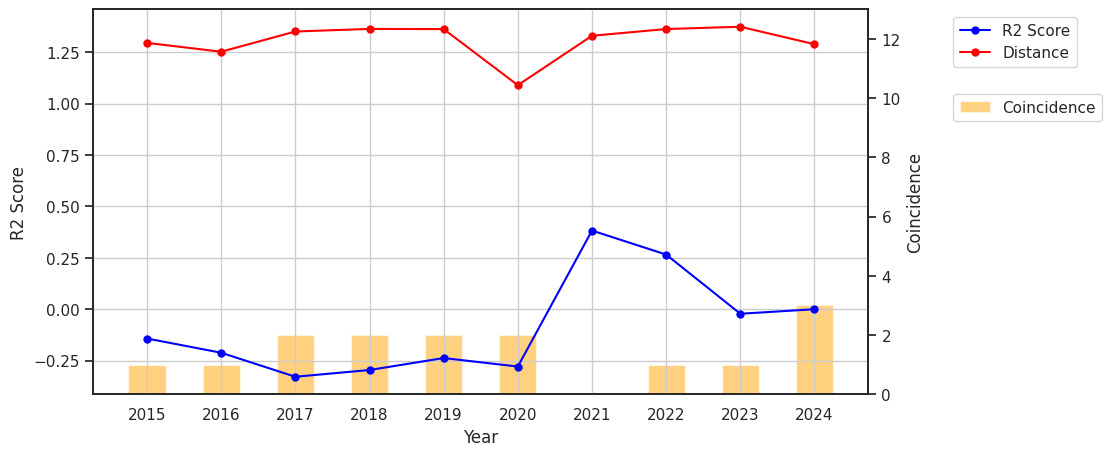

In [14]:
from drift_prediction import predict_sklearn

data = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism.csv', sep=";", decimal=".", encoding="utf-8")
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%Y-%m')

years = data['Fecha'].dt.year.unique()

measure_by_year = {}
distance_by_year = {}
coincidence = {}
starting_year = 2015

train = data[data['Fecha'].dt.year < starting_year]
rest = data[data['Fecha'].dt.year >= starting_year]

X_train = train.drop(columns=['Suecia', 'Fecha'])
Y_train = train['Suecia']

ia = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
# ia = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=5000)
# ia = LinearRegression()

ia.fit(X_train, Y_train)

for year in years[np.where(years >= starting_year)]:
    test = data[data['Fecha'].dt.year == year]

    X_test = test.drop(columns=['Suecia', 'Fecha'])
    Y_test = test['Suecia']

    pred, xai, measure = predict(
        ia,
        shap.Explainer(ia),
        X_train,
        X_test,
        Y_test,
        distance_metric='manhattan'
    ) 
    coincidence[year] = sum(np.array(xai['Previous explained importance'].sort_values(ascending=False).index) == np.array(xai['Test explained importance'].sort_values(ascending=False).index))
    measure_by_year[year] = measure
    distance_by_year[year] = xai['Distance'].mean()

coincedence_by_year = pd.Series(coincidence)
measure_by_year = pd.Series(measure_by_year)
distance_by_year = pd.Series(distance_by_year)

sns.set_theme(style="white")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax.twinx()
ax.set_zorder(2)
ax2.set_zorder(1)
ax.patch.set_visible(False)

ax2.bar(coincedence_by_year.index, coincedence_by_year.values, color='orange', alpha=0.5, label='Coincidence', width=0.5)
sns.lineplot(x=years[np.where(years >= starting_year)], y=measure_by_year.values, ax=ax, color='blue', label='R2 Score', marker='o', markeredgewidth=0)
sns.lineplot(x=years[np.where(years >= starting_year)], y=distance_by_year.values, ax=ax, color='red', label='Distance', marker='o', markeredgewidth=0)

ax.set_ylabel('R2 Score')
ax2.set_ylabel('Coincidence')
ax2.set_ylim(0, len(train.columns))
ax.set_xlabel('Year')
ax.set_xticks(years[np.where(years >= starting_year)])
ax.grid(axis='y')
ax.grid(axis='x')
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.8))

fig.show()
    

- ARREGLA EL MODELO
- TENER EN CEUNTA EL TIEMPO HACIENDO COLUMNAS POR MES

## Insertar datos temporales en columnas

In [ ]:
df['year'] = df['Fecha'].dt.year
df['month'] = df['Fecha'].dt.month
df.pop('Fecha')

In [98]:
# Create new column names with the format 'columnname_month'
new_columns = [f"{col}_{month}" for col in df.columns if col not in ['year', 'month'] for month in range(1, 13)]

# Create a new dictionary to store transformed data
transformed_data = {}

# Group data by year and create a new dictionary entry for each year
for year, group in df.groupby('year'):
    transformed_data[year] = {}
    for col in df.columns:
        if col not in ['year', 'month']:
            for idx, month in group.iterrows():
                transformed_data[year][f"{col}_{int(month['month'])}"] = month[col]


# Convert transformed data into a DataFrame
time_based_df = pd.DataFrame.from_dict(transformed_data, orient='index')

# # Reorder columns to match the order in new_columns
time_based_df = time_based_df[new_columns]

time_based_df.head()

,Suecia_1,Suecia_2,Suecia_3,Suecia_4,Suecia_5,Suecia_6,Suecia_7,Suecia_8,Suecia_9,Suecia_10,...,Búsquedas hacia AGP 6 meses_3,Búsquedas hacia AGP 6 meses_4,Búsquedas hacia AGP 6 meses_5,Búsquedas hacia AGP 6 meses_6,Búsquedas hacia AGP 6 meses_7,Búsquedas hacia AGP 6 meses_8,Búsquedas hacia AGP 6 meses_9,Búsquedas hacia AGP 6 meses_10,Búsquedas hacia AGP 6 meses_11,Búsquedas hacia AGP 6 meses_12
2005,7351.0,8935.0,12503.0,11537.0,14012.0,17213.0,18586.0,7919.0,10936.0,16968.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006,8110.0,7640.0,11805.0,13317.0,13253.0,20688.0,13952.0,8463.0,10431.0,14710.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007,6864.0,9916.0,12940.0,17210.0,13974.0,16823.0,20202.0,10213.0,16300.0,21119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008,6840.0,10026.0,16309.0,17313.0,15297.0,15869.0,18615.0,10194.0,17483.0,16650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,5405.0,5459.0,11484.0,11490.0,10506.0,11657.0,14258.0,4927.0,9739.0,12771.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


MSE:  18024900.004667304


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


MSE:  98632010.76322496


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


MSE:  340667432.0284693


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


MSE:  605736515.2412249


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


MSE:  803292204.6080998


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


MSE:  1182866354.15925


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


MSE:  1920413113.0753362


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


MSE:  2110461548.8575995


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


MSE:  1965377353.905877


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


MSE:  105252.12133402623


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


MSE:  138645601.04551107


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


MSE:  959398587.7055998


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


MSE:  842476360.6965442


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


MSE:  151756590.69725624


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


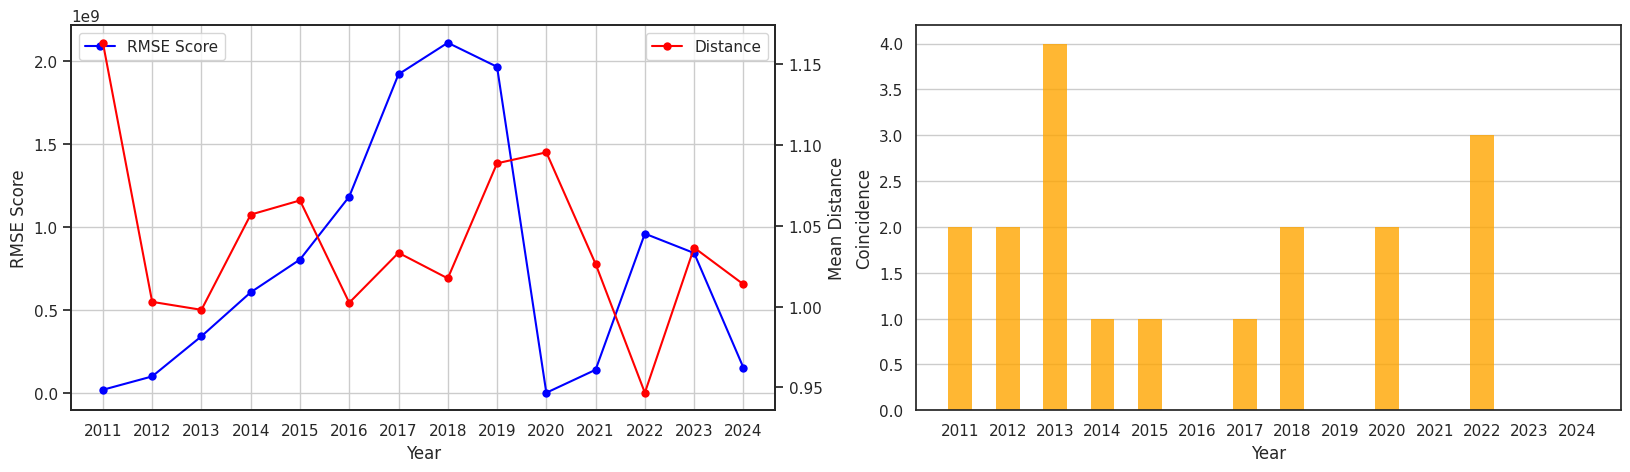

In [104]:
from drift_prediction import predict_sklearn

year_division = 2010

train, rest = (time_based_df[time_based_df.index <= year_division], time_based_df[time_based_df.index > year_division])
X_train = train.drop(columns=['Suecia_1', 'Suecia_2', 'Suecia_3', 'Suecia_4', 'Suecia_5', 'Suecia_6', 'Suecia_7', 'Suecia_8', 'Suecia_9', 'Suecia_10', 'Suecia_11', 'Suecia_12'])
y_train = train[['Suecia_1', 'Suecia_2', 'Suecia_3', 'Suecia_4', 'Suecia_5', 'Suecia_6', 'Suecia_7', 'Suecia_8', 'Suecia_9', 'Suecia_10', 'Suecia_11', 'Suecia_12']].mean(axis=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=5000)
model.fit(X_train, y_train)

coincidence = {}
measure_by_year = {}
distance_by_year = {}

for year in rest.index.to_list():
    test = rest.loc[[year]]

    X_test = test.drop(columns=['Suecia_1', 'Suecia_2', 'Suecia_3', 'Suecia_4', 'Suecia_5', 'Suecia_6', 'Suecia_7', 'Suecia_8', 'Suecia_9', 'Suecia_10', 'Suecia_11', 'Suecia_12'])
    y_test = test[['Suecia_1', 'Suecia_2', 'Suecia_3', 'Suecia_4', 'Suecia_5', 'Suecia_6', 'Suecia_7', 'Suecia_8', 'Suecia_9', 'Suecia_10', 'Suecia_11', 'Suecia_12']].mean(axis=1)

    pred, xai, measure = predict(
        RF,
        shap.KernelExplainer(model.predict, X_train),
        X_train,
        X_test,
        y_test,
        distance_metric='manhattan'
    )
    coincidence[year] = sum(np.array(xai['Previous explained importance'].sort_values(ascending=False).index) == np.array(xai['Test explained importance'].sort_values(ascending=False).index))
    measure_by_year[year] = measure
    distance_by_year[year] = xai['Distance'].mean()
    # print(f"{year}\n-------------------\nCoincidence: {coincidence[year]}\nMAE: {measure}\nMean Distance: {distance_by_year[year]}\n\n")


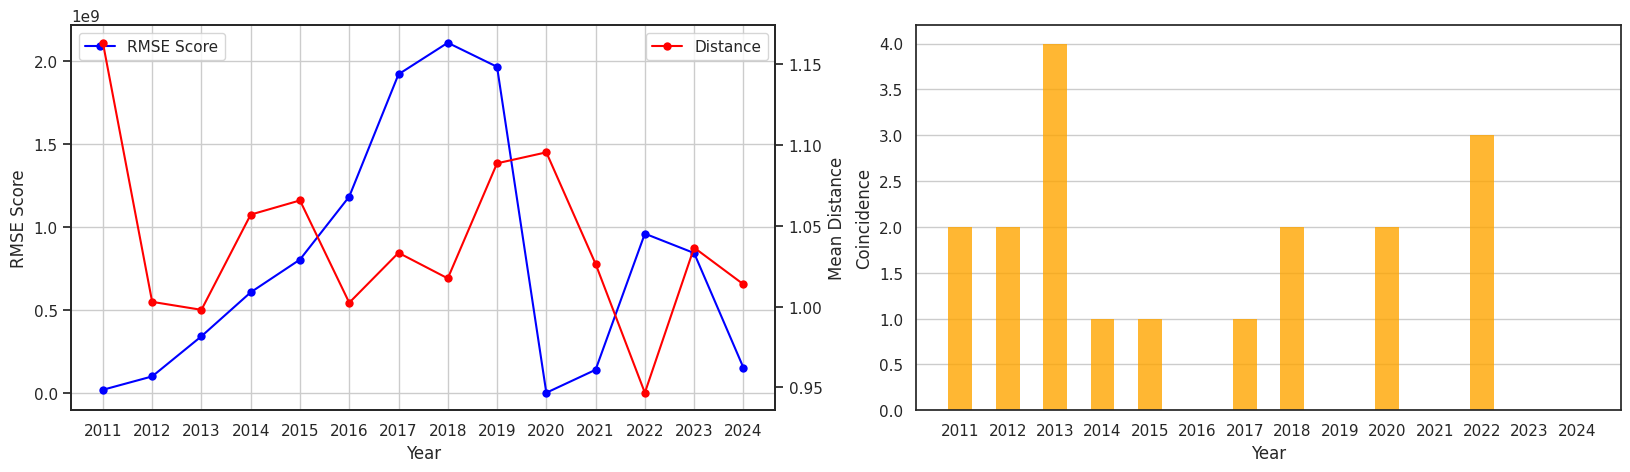

In [107]:

coincedence_by_year = pd.Series(coincidence)
measure_by_year = pd.Series(measure_by_year)
distance_by_year = pd.Series(distance_by_year)

sns.set_theme(style="white")
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax2 = ax[0].twinx()

ax[1].bar(coincedence_by_year.index, coincedence_by_year.values, color='orange', alpha=0.8, label='Coincidence', width=0.5, linewidth=0)
ax[1].xaxis.set_ticks(coincedence_by_year.index)
sns.lineplot(x=rest.index.to_list(), y=measure_by_year.values, ax=ax[0], color='blue', label='RMSE Score', marker='o', markeredgewidth=0)
sns.lineplot(x=rest.index.to_list(), y=distance_by_year.values, ax=ax2, color='red', label='Distance', marker='o', markeredgewidth=0)

ax[0].xaxis.set_ticks(rest.index.to_list())
ax[0].set_ylabel('RMSE Score')
ax[0].set_xlabel('Year')
ax[0].grid(axis='y')
ax[0].grid(axis='x')
ax[0].legend(loc='upper left')
ax2.set_ylabel('Mean Distance')
ax2.legend(loc='upper right')
ax[1].set_ylabel('Coincidence')
ax[1].set_xlabel('Year')
ax[1].grid(axis='y')

fig.show()
